This dataset is a combination of COVID-19, Lung-Opacity, Normal, Viral Pneumonia and Tuberculosis classes.
---------------------------------------
Class Name: Number of samples : Labels
---------------------------------------
COVID-19 :  4,189 : 0
Lung-Opacity : 6,012 : 1
Normal : 10,192 : 2
Viral Pneumonia : 7,397 : 3
Tuberculosis : 4,897 : 4
------------------------------
Total : 32,687
------------------------------

### Convert npz to png files

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def preprocess_and_save_images(file_path, output_dir):
    data = np.load(file_path)

    os.makedirs(output_dir, exist_ok=True)

    startIndex = 19380
    for i, (image, label) in enumerate(zip(data['image'][startIndex:], data['image_label'][startIndex:])):
        label_dir = os.path.join(output_dir, str(label[0]))
        os.makedirs(label_dir, exist_ok=True)

        filename = os.path.join(label_dir, f"{i + startIndex}.png")

        plt.imshow(image / 255.0)
        plt.axis('off')
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)  

        plt.close()  

<div style="color:red">WARNING: This loads the whole numpy array in to your memory! train.npz needs at least 32GB of RAM!</div>

Download images from here and skip this step: [https://drive.google.com/file/d/1i_SZfdp39UAIYCRz61O_OPto4ltv0HfW/view?usp=sharing](https://drive.google.com/file/d/1i_SZfdp39UAIYCRz61O_OPto4ltv0HfW/view?usp=sharing)  

Or download the npz files and convert to png yourself: [https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/WNQ3GI](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/WNQ3GI) 

In [4]:
preprocess_and_save_images("train.npz", "images/train")

In [3]:
preprocess_and_save_images("test.npz", "images/test")

In [ ]:
preprocess_and_save_images("val.npz", "images/val")

In [83]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image, ImageReadMode
import numpy as np

### Define the Dataloder for the dataset

In [118]:
class XRayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.img_paths = self._get_img_paths()

    def _get_img_paths(self):
        img_paths = []
        for cls_name in self.classes:
            cls_dir = os.path.join(self.root_dir, cls_name)
            for img_name in os.listdir(cls_dir):
                img_path = os.path.join(cls_dir, img_name)
                img_paths.append((img_path, int(cls_name)))
        return img_paths

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path, label = self.img_paths[idx]
        image = read_image(img_path, mode=ImageReadMode.GRAY)
        image = image.float() / 255.0

        if self.transform:
            image = self.transform(image)
        return image, label

In [68]:
train_dir = 'images/train'
test_dir = 'images/test'
val_dir = 'images/val'

In [119]:
train_dataset = XRayDataset(train_dir)
test_dataset = XRayDataset(test_dir)
val_dataset = XRayDataset(val_dir)

In [120]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

### Show one example image

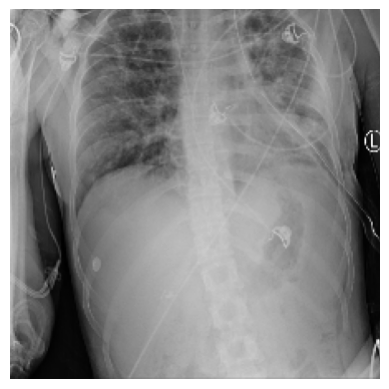

Label: tensor(3)


In [134]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(iter(train_loader))

image = images[0].permute(1, 2, 0).numpy()  
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

print("Label:", labels[0])


## Define Neural Network

In [107]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [108]:
num_classes = 5

#### Using own model implementation

In [109]:
class Model(nn.Module):
    def __init__(self, num_classes=5):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # 1 input channel for grayscale images
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 92 * 92, 128)  # 369px / 2 / 2 = 92
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 92 * 92)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [110]:
model = Model()

#### Using pretrained model

In [ ]:
import torchvision.models as models

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

### Define Loss Function and Optimizer Function

In [111]:
import torch

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [132]:
num_epochs = 2
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        print(f"Epoch {epoch + 1}/{num_epochs}, Batch {i + 1}/{len(train_loader)}")
        inputs, labels = data
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0


Epoch 1/2, Batch 1/613
Epoch 1/2, Batch 2/613
Epoch 1/2, Batch 3/613
Epoch 1/2, Batch 4/613
Epoch 1/2, Batch 5/613
Epoch 1/2, Batch 6/613
Epoch 1/2, Batch 7/613
Epoch 1/2, Batch 8/613
Epoch 1/2, Batch 9/613
Epoch 1/2, Batch 10/613
Epoch 1/2, Batch 11/613
Epoch 1/2, Batch 12/613
Epoch 1/2, Batch 13/613
Epoch 1/2, Batch 14/613
Epoch 1/2, Batch 15/613
Epoch 1/2, Batch 16/613
Epoch 1/2, Batch 17/613
Epoch 1/2, Batch 18/613
Epoch 1/2, Batch 19/613
Epoch 1/2, Batch 20/613
Epoch 1/2, Batch 21/613
Epoch 1/2, Batch 22/613
Epoch 1/2, Batch 23/613
Epoch 1/2, Batch 24/613
Epoch 1/2, Batch 25/613
Epoch 1/2, Batch 26/613
Epoch 1/2, Batch 27/613
Epoch 1/2, Batch 28/613
Epoch 1/2, Batch 29/613
Epoch 1/2, Batch 30/613
Epoch 1/2, Batch 31/613
Epoch 1/2, Batch 32/613
Epoch 1/2, Batch 33/613
Epoch 1/2, Batch 34/613
Epoch 1/2, Batch 35/613
Epoch 1/2, Batch 36/613
Epoch 1/2, Batch 37/613
Epoch 1/2, Batch 38/613
Epoch 1/2, Batch 39/613
Epoch 1/2, Batch 40/613
Epoch 1/2, Batch 41/613
Epoch 1/2, Batch 42/613
E

### Calculate Accuracy

In [133]:
correct = 0
total = 0
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        images, labels = data
        print(f"Done: {total}/{len(test_loader.dataset)}")
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Done: 0/6540
Done: 32/6540
Done: 64/6540
Done: 96/6540
Done: 128/6540
Done: 160/6540
Done: 192/6540
Done: 224/6540
Done: 256/6540
Done: 288/6540
Done: 320/6540
Done: 352/6540
Done: 384/6540
Done: 416/6540
Done: 448/6540
Done: 480/6540
Done: 512/6540
Done: 544/6540
Done: 576/6540
Done: 608/6540
Done: 640/6540
Done: 672/6540
Done: 704/6540
Done: 736/6540
Done: 768/6540
Done: 800/6540
Done: 832/6540
Done: 864/6540
Done: 896/6540
Done: 928/6540
Done: 960/6540
Done: 992/6540
Done: 1024/6540
Done: 1056/6540
Done: 1088/6540
Done: 1120/6540
Done: 1152/6540
Done: 1184/6540
Done: 1216/6540
Done: 1248/6540
Done: 1280/6540
Done: 1312/6540
Done: 1344/6540
Done: 1376/6540
Done: 1408/6540
Done: 1440/6540
Done: 1472/6540
Done: 1504/6540
Done: 1536/6540
Done: 1568/6540
Done: 1600/6540
Done: 1632/6540
Done: 1664/6540
Done: 1696/6540
Done: 1728/6540
Done: 1760/6540
Done: 1792/6540
Done: 1824/6540
Done: 1856/6540
Done: 1888/6540
Done: 1920/6540
Done: 1952/6540
Done: 1984/6540
Done: 2016/6540
Done: 2048/65

### Saving the model

In [135]:
torch.save(model.state_dict(), 'xray_v1.pth')